# ML models assessment

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

### Import dataset

In [2]:
data = pd.read_csv('../../datasets/data-stemmed.csv')
data.info()
nan_count = data['processed text'].isnull().sum()
print(f'Number of NaN values: {nan_count}') # 2 NaN values (non so il perchè, nel file di stemming non uscivano)
print(f'Number of rows: {len(data)}')
data = data.dropna(subset=['processed text'])
print(f'Number of rows after dropping NaN values: {len(data)}')
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4078 entries, 0 to 4077
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   text                 4078 non-null   object 
 1   quotes               4078 non-null   int64  
 2   is.retweet           4078 non-null   bool   
 3   external.link        4078 non-null   bool   
 4   pictures             4078 non-null   bool   
 5   videos               4078 non-null   bool   
 6   gifs                 4078 non-null   bool   
 7   multimedial_content  4078 non-null   bool   
 8   user.image           4078 non-null   bool   
 9   user.bio             4078 non-null   bool   
 10  user.website         4078 non-null   bool   
 11  user.tweets          4078 non-null   int64  
 12  user.following       4078 non-null   int64  
 13  user.media           4078 non-null   int64  
 14  engagement.rate      4078 non-null   float64
 15  n_hashtags           4078 non-null   i

,text,quotes,is.retweet,external.link,pictures,videos,gifs,multimedial_content,user.image,user.bio,user.website,user.tweets,user.following,user.media,engagement.rate,n_hashtags,processed text
0,Fried Chicken with Hot 🔥 Sauce Corn Muffin and...,1,True,False,True,False,False,True,True,True,True,16213,549,15698,0.571817,8,fri chicken hot fire sauc corn muffin season f...
1,#Morel #mushrooms at center of #food #poisonin...,0,False,False,False,False,False,False,True,True,True,50098,513,1962,0.000000,10,morel mushroom center food poison outbreak fun...
2,My Blog:: Obama Legacy Facing REVISIT ... Ian...,0,False,False,False,False,False,False,True,True,True,5174,9022,0,0.008527,11,blog obama legaci face revisit ianrmackintoshb...
3,Craving sushi but tired of expensive takeout? ...,0,False,False,False,False,False,False,True,True,True,108071,678,49647,0.000000,6,crave sushi tire expens takeout look kellylov ...
4,Potato Pancakes should not be a rare side dish...,0,False,False,True,False,False,True,True,True,True,28081,2343,18032,0.000000,8,potato pancak rare side dish plan leftov time ...


### Perform vectrorization

Perform here the division between covariates and target variable in order to easen the code later on

In [3]:
data.drop(['text'], axis=1, inplace=True)
Y = data['engagement.rate']
data['engagement.rate'].fillna(data['engagement.rate'].mean(), inplace=True)
X = data.drop(columns=['engagement.rate'])
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4078 entries, 0 to 4077
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   quotes               4078 non-null   int64 
 1   is.retweet           4078 non-null   bool  
 2   external.link        4078 non-null   bool  
 3   pictures             4078 non-null   bool  
 4   videos               4078 non-null   bool  
 5   gifs                 4078 non-null   bool  
 6   multimedial_content  4078 non-null   bool  
 7   user.image           4078 non-null   bool  
 8   user.bio             4078 non-null   bool  
 9   user.website         4078 non-null   bool  
 10  user.tweets          4078 non-null   int64 
 11  user.following       4078 non-null   int64 
 12  user.media           4078 non-null   int64 
 13  n_hashtags           4078 non-null   int64 
 14  processed text       4078 non-null   object
dtypes: bool(9), int64(5), object(1)
memory usage: 227.1+ KB

In [6]:
# label encoding
# max_df will be set with regard of the best parameter found in the previous step
vectorizer = TfidfVectorizer(min_df=2, max_df=0.99) # ignore terms that appear in more than 99% of the documents and in less than 2 documents

dtm = vectorizer.fit_transform(X['processed text'])
# DTM is a document-term matrix with shape (n_samples, n_features) having as rows the documents and as columns the terms learned as vocabulary
# The value of each cell is the tf-idf score


# Convert sparse matrix to dense matrix
dense_matrix = dtm.toarray()

# Display non-zero elements
non_zero_elements = dense_matrix[dense_matrix != 0]
print(len(non_zero_elements))
print(non_zero_elements)

# Convert the DTM to a dataframe
dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

# # Calculate the threshold for removal
# threshold = 0.001 * len(X)  # For example, keep terms that appear in at least 1% of documents
# dtm_df = dtm_df.loc[:, dtm_df.sum() >= threshold]

# Merge the two dataframes
# Reset the indexes of both X and dtm_df
X.reset_index(drop=True, inplace=True)
dtm_df.reset_index(drop=True, inplace=True)

# Concatenate the DataFrames
merged_df = pd.concat([X, dtm_df], axis=1)
X.fillna(0, inplace=True)
flag=False
if 'engagement.rate' in X.columns:
    flag = True
print(f'{flag}')
merged_df.head(5)

59436
[0.17732438 0.27265551 0.20610443 ... 0.86084528 0.12009352 0.49449262]
False


,quotes,is.retweet,external.link,pictures,videos,gifs,multimedial_content,user.image,user.bio,user.website,...,像素,全麥,夕ごはんsparkl,提拉米蘇,料理好きな人と繋がりたい,曲奇,美女,美食,飯テロ同好会,𝗪𝗲𝗯𝘀𝗶𝘁𝗲
0,1,True,False,True,False,False,True,True,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,False,False,False,False,False,False,True,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,False,False,False,False,False,False,True,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,False,False,False,False,False,False,True,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,False,False,True,False,False,True,True,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Drop the text column, as processed text will be the covariate of interest.
Then perform the X, Y division, where Y will be engagement rate

In [18]:
X.drop(columns=['processed text'], inplace=True)
X.head(5)

,quotes,is.retweet,external.link,pictures,videos,gifs,multimedial_content,user.image,user.bio,user.website,user.tweets,user.following,user.media,n_hashtags
0,1,True,False,True,False,False,True,True,True,True,16213,549,15698,8
1,0,False,False,False,False,False,False,True,True,True,50098,513,1962,10
2,0,False,False,False,False,False,False,True,True,True,5174,9022,0,11
3,0,False,False,False,False,False,False,True,True,True,108071,678,49647,6
4,0,False,False,True,False,False,True,True,True,True,28081,2343,18032,8


In [19]:
# dataframe for storing results in a convenient way for shwing boxplot later
reg_metrics = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'MAPE', 'R2'])

### Dummy regressor

We are going to use a dummy regressor (that estimates the mean of the output variable) as a baseline.

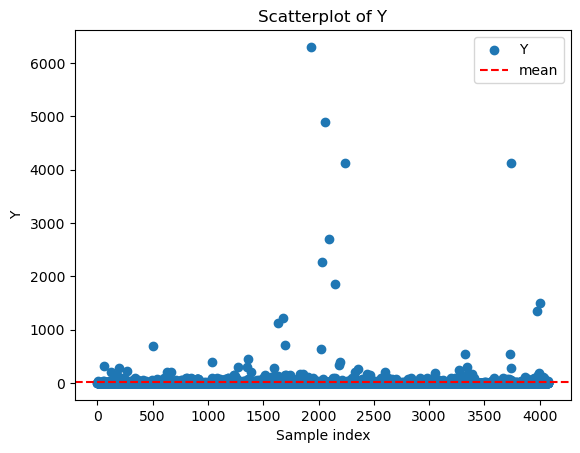

MSE Scores: 0     20.905211
1    205.916471
2     26.683294
3     97.686300
4     24.938445
5     69.325365
6    139.268819
7    267.226543
8    373.725777
9    127.873488
Name: RMSE, dtype: float64
Mean MSE: 135.3549713383933


In [20]:
dummy_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in dummy_kfolds.split(X):
    dummy_regressor = DummyRegressor()
    dummy_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_dummy_reg = dummy_regressor.predict(X.iloc[test_idx])
    current_dummy_mae = mean_absolute_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_mse = mean_squared_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_rmse = np.sqrt(current_dummy_mse)
    current_dummy_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_r2 = r2_score(Y.iloc[test_idx], y_dummy_reg)
    reg_metrics.loc[len(reg_metrics)] = ['DUMMY', current_dummy_mae, current_dummy_rmse, current_dummy_mape, current_dummy_r2]

# Dovrebbe essere lo stesso di fare:
# lin_regressor = LinearRegression()
# Y_reshaped = Y.values.reshape(-1, 1)

# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics.loc[len(reg_metrics)] = ['DUMMY', mae_scores, mse_scores, mape_scores]


#Scatterplot of Y
mean_y = np.mean(Y)
plt.scatter(np.arange(len(Y)), Y, label='Y')
plt.axhline(y=mean_y, color='r', linestyle='--', label='mean')    # Plot the mean
plt.title('Scatterplot of Y')
plt.xlabel('Sample index')
plt.ylabel('Y')
plt.legend()
plt.show()

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics.loc[reg_metrics['Model']=='DUMMY','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics.loc[reg_metrics['Model']=='DUMMY','RMSE'])}")

We can see that the dummy classifier doesn't do much, as with few outliers, but that generates much leverage, the MSE is indeed very high

## Single decision tree

In [21]:
# Decision Tree Regressor
# Initialize a decision tree regressor instance
tree_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in tree_kfolds.split(X):
    tree_regressor = DecisionTreeRegressor()
    tree_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_tree_reg = tree_regressor.predict(X.iloc[test_idx])
    current_tree_mae = mean_absolute_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_mse = mean_squared_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_rmse = np.sqrt(current_tree_mse)
    current_tree_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_r2 = r2_score(Y.iloc[test_idx], y_tree_reg)
    reg_metrics.loc[len(reg_metrics)] = ['TREE', current_tree_mae, current_tree_rmse, current_tree_mape, current_tree_r2]

# Dovrebbe essere lo stesso di fare:
# rf = RandomForestRegressor()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(rd, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(rf, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(rf, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics.loc[len(reg_metrics)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics.loc[reg_metrics['Model']=='TREE','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics.loc[reg_metrics['Model']=='TREE','RMSE'])}")

MSE Scores: 10    189.859804
11    151.169926
12    248.284973
13     35.665033
14     42.973081
15    264.912119
16     52.482857
17     52.571291
18     68.509449
19    474.512066
Name: RMSE, dtype: float64
Mean MSE: 158.09405983412339


## RandomForest

In [22]:
# Random Forest Regressor
# Initialize a random forest regressor instance
rf_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in rf_kfolds.split(X):
    rf_regressor = RandomForestRegressor()
    rf_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_rf_reg = rf_regressor.predict(X.iloc[test_idx])
    current_rf_mae = mean_absolute_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_mse = mean_squared_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_rmse = np.sqrt(current_rf_mse)
    current_rf_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_r2 = r2_score(Y.iloc[test_idx], y_rf_reg)
    reg_metrics.loc[len(reg_metrics)] = ['RF', current_rf_mae, current_rf_rmse, current_rf_mape, current_rf_r2]
     
# Dovrebbe essere lo stesso di fare:
# dummy_regressor = DummyRegressor()

# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(lin_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(lin_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(lin_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics.loc[len(reg_metrics)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics.loc[reg_metrics['Model']=='RF','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics.loc[reg_metrics['Model']=='RF','RMSE'])}")

MSE Scores: 20    153.564374
21    105.197582
22    124.400686
23     87.791127
24    106.737169
25    249.551121
26     42.885415
27    298.793573
28    340.742637
29    135.796265
Name: RMSE, dtype: float64
Mean MSE: 164.54599491370146


## SVM

In [23]:
sv_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in sv_kfolds.split(X):
    sv_regressor = SVR()
    sv_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_sv_reg = sv_regressor.predict(X.iloc[test_idx])
    current_sv_mae = mean_absolute_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_mse = mean_squared_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_rmse = np.sqrt(current_sv_mse)
    current_sv_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_r2 = r2_score(Y.iloc[test_idx], y_sv_reg)
    reg_metrics.loc[len(reg_metrics)] = ['SVM', current_sv_mae, current_sv_rmse, current_sv_mape, current_sv_r2]

# Dovrebbe essere lo stesso di fare:
# sv_regressor = SVR()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(sv_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(sv_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(sv_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics.loc[len(reg_metrics)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics.loc[reg_metrics['Model']=='SVM','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics.loc[reg_metrics['Model']=='SVM','RMSE'])}")

MSE Scores: 30     89.419979
31    318.830561
32    137.234087
33     27.104004
34     17.892093
35    114.966959
36    210.354148
37     14.394205
38     92.469809
39    333.818422
Name: RMSE, dtype: float64
Mean MSE: 135.6484267123497


## kNearestNeighbor

In [24]:
knn_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in knn_kfolds.split(X):
    knn_regressor = KNeighborsRegressor()
    knn_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_knn_reg = knn_regressor.predict(X.iloc[test_idx])
    current_knn_mae = mean_absolute_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_mse = mean_squared_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_rmse = np.sqrt(current_knn_mse)
    current_knn_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_r2 = r2_score(Y.iloc[test_idx], y_knn_reg)
    reg_metrics.loc[len(reg_metrics)] = ['KNN', current_knn_mae, current_knn_rmse, current_knn_mape, current_knn_r2]

# Dovrebbe essere lo stesso di fare:
# knn_regressor = KNeighborsRegressor()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(knn_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(knn_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(knn_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics.loc[len(reg_metrics)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics.loc[reg_metrics['Model']=='KNN','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics.loc[reg_metrics['Model']=='KNN','RMSE'])}")

MSE Scores: 40    139.190750
41     89.254635
42    111.196727
43    237.578556
44    117.825186
45    398.721786
46    261.756792
47    111.030087
48     75.132788
49    163.615833
Name: RMSE, dtype: float64
Mean MSE: 170.5303138997419


## Some plots

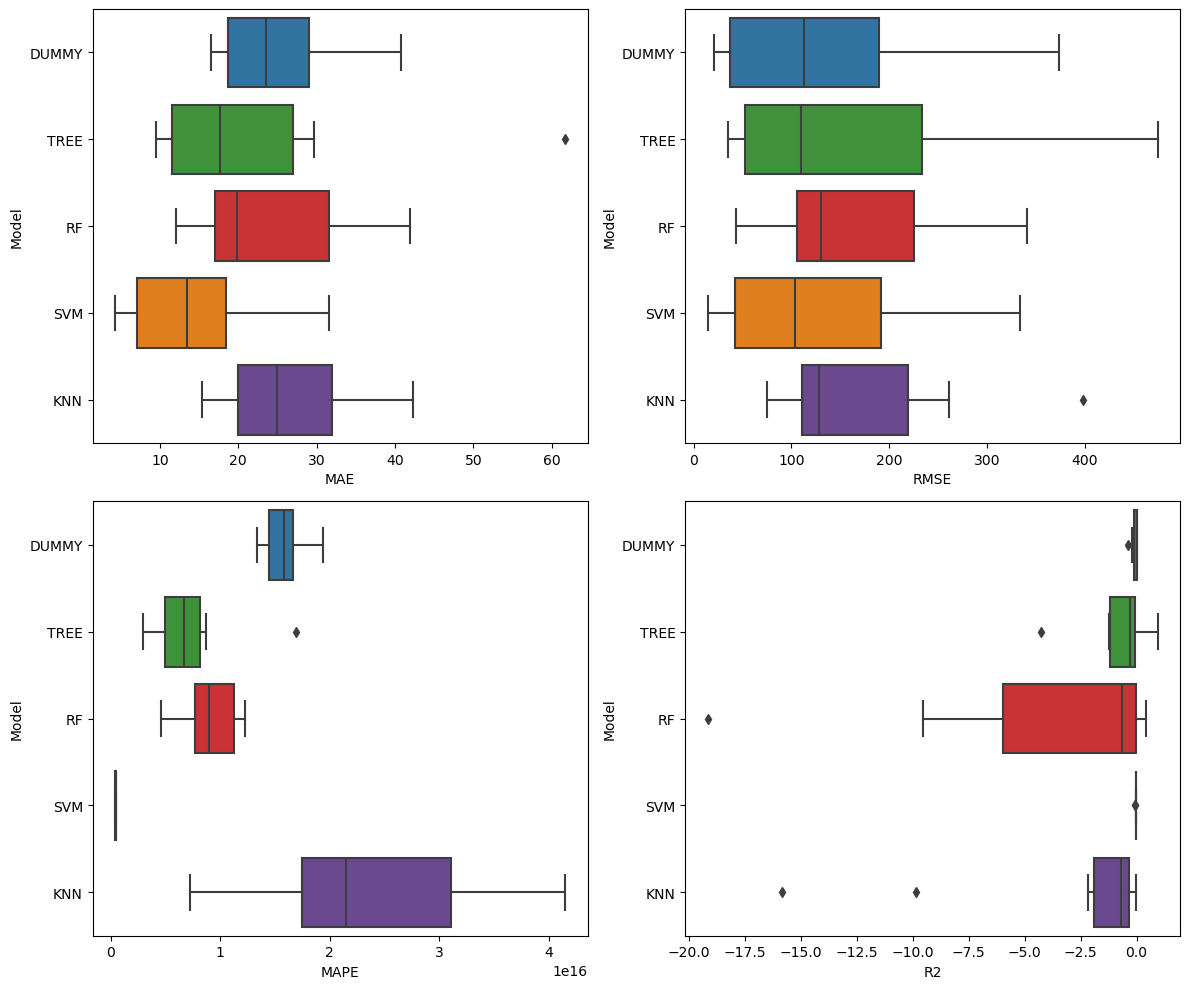

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(data=reg_metrics, x="MAE", y="Model", ax=axs[0, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="RMSE", y="Model", ax=axs[0, 1], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="MAPE", y="Model", ax=axs[1, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="R2", y="Model", ax=axs[1, 1], palette=sns.color_palette('Paired')[1::2])


plt.tight_layout()
plt.show()

## Use only multimedial data

In [26]:
X.drop(columns=['pictures', 'videos', 'gifs'], inplace=True)

In [27]:
reg_metrics_new = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'MAPE', 'R2'])

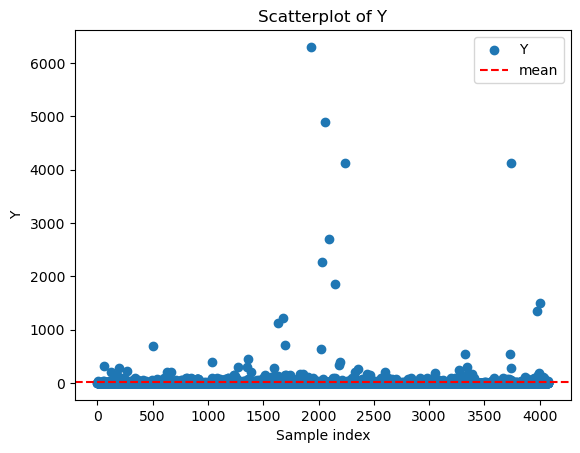

MSE Scores: 0    118.149041
1     43.170979
2     81.317129
3     51.480688
4    207.338955
5    135.836598
6     63.429454
7    331.614543
8    322.738580
9     23.444118
Name: RMSE, dtype: float64
Mean MSE: 137.8520084459399


In [28]:
dummy_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in dummy_kfolds.split(X):
    dummy_regressor = DummyRegressor()
    dummy_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_dummy_reg = dummy_regressor.predict(X.iloc[test_idx])
    current_dummy_mae = mean_absolute_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_mse = mean_squared_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_rmse = np.sqrt(current_dummy_mse)
    current_dummy_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_r2 = r2_score(Y.iloc[test_idx], y_dummy_reg)
    reg_metrics_new.loc[len(reg_metrics_new)] = ['DUMMY', current_dummy_mae, current_dummy_rmse, current_dummy_mape, current_dummy_r2]

# Dovrebbe essere lo stesso di fare:
# lin_regressor = LinearRegression()
# Y_reshaped = Y.values.reshape(-1, 1)

# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_new.loc[len(reg_metrics_new)] = ['DUMMY', mae_scores, mse_scores, mape_scores]


#Scatterplot of Y
mean_y = np.mean(Y)
plt.scatter(np.arange(len(Y)), Y, label='Y')
plt.axhline(y=mean_y, color='r', linestyle='--', label='mean')    # Plot the mean
plt.title('Scatterplot of Y')
plt.xlabel('Sample index')
plt.ylabel('Y')
plt.legend()
plt.show()

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_new.loc[reg_metrics_new['Model']=='DUMMY','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_new.loc[reg_metrics_new['Model']=='DUMMY','RMSE'])}")

In [29]:
# Decision Tree Regressor
# Initialize a decision tree regressor instance
tree_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in tree_kfolds.split(X):
    tree_regressor = DecisionTreeRegressor()
    tree_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_tree_reg = tree_regressor.predict(X.iloc[test_idx])
    current_tree_mae = mean_absolute_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_mse = mean_squared_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_rmse = np.sqrt(current_tree_mse)
    current_tree_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_r2 = r2_score(Y.iloc[test_idx], y_tree_reg)
    reg_metrics_new.loc[len(reg_metrics_new)] = ['TREE', current_tree_mae, current_tree_rmse, current_tree_mape, current_tree_r2]

# Dovrebbe essere lo stesso di fare:
# rf = RandomForestRegressor()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(rd, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(rf, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(rf, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_new.loc[len(reg_metrics_new)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_new.loc[reg_metrics_new['Model']=='TREE','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_new.loc[reg_metrics_new['Model']=='TREE','RMSE'])}")

MSE Scores: 10    340.969908
11    137.243592
12    238.838166
13     44.320019
14     45.246408
15    214.059600
16    148.946613
17    153.954039
18    253.233082
19    246.779552
Name: RMSE, dtype: float64
Mean MSE: 182.35909811675182


In [30]:
# Random Forest Regressor
# Initialize a random forest regressor instance
rf_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in rf_kfolds.split(X):
    rf_regressor = RandomForestRegressor()
    rf_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_rf_reg = rf_regressor.predict(X.iloc[test_idx])
    current_rf_mae = mean_absolute_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_mse = mean_squared_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_rmse = np.sqrt(current_rf_mse)
    current_rf_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_r2 = r2_score(Y.iloc[test_idx], y_rf_reg)
    reg_metrics_new.loc[len(reg_metrics_new)] = ['RF', current_rf_mae, current_rf_rmse, current_rf_mape, current_rf_r2]
     
# Dovrebbe essere lo stesso di fare:
# dummy_regressor = DummyRegressor()

# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(lin_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(lin_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(lin_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_new.loc[len(reg_metrics_new)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_new.loc[reg_metrics_new['Model']=='RF','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_new.loc[reg_metrics_new['Model']=='RF','RMSE'])}")

MSE Scores: 20    297.123727
21     57.144057
22     45.268204
23    252.271452
24    178.823405
25    318.381123
26    120.269089
27    152.255031
28     67.888372
29     71.068399
Name: RMSE, dtype: float64
Mean MSE: 156.04928584144054


In [31]:
sv_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in sv_kfolds.split(X):
    sv_regressor = SVR()
    sv_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_sv_reg = sv_regressor.predict(X.iloc[test_idx])
    current_sv_mae = mean_absolute_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_mse = mean_squared_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_rmse = np.sqrt(current_sv_mse)
    current_sv_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_r2 = r2_score(Y.iloc[test_idx], y_sv_reg)
    reg_metrics_new.loc[len(reg_metrics_new)] = ['SVM', current_sv_mae, current_sv_rmse, current_sv_mape, current_sv_r2]

# Dovrebbe essere lo stesso di fare:
# sv_regressor = SVR()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(sv_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(sv_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(sv_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_new.loc[len(reg_metrics_new)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_new.loc[reg_metrics_new['Model']=='SVM','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_new.loc[reg_metrics_new['Model']=='SVM','RMSE'])}")

MSE Scores: 30     33.935386
31    304.732780
32     49.872648
33    321.167438
34     19.467412
35    206.446289
36     48.751287
37     15.717968
38    207.663604
39    136.586797
Name: RMSE, dtype: float64
Mean MSE: 134.43416120888267


In [32]:
knn_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in knn_kfolds.split(X):
    knn_regressor = KNeighborsRegressor()
    knn_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_knn_reg = knn_regressor.predict(X.iloc[test_idx])
    current_knn_mae = mean_absolute_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_mse = mean_squared_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_rmse = np.sqrt(current_knn_mse)
    current_knn_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_r2 = r2_score(Y.iloc[test_idx], y_knn_reg)
    reg_metrics_new.loc[len(reg_metrics_new)] = ['KNN', current_knn_mae, current_knn_rmse, current_knn_mape, current_knn_r2]

# Dovrebbe essere lo stesso di fare:
# knn_regressor = KNeighborsRegressor()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(knn_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(knn_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(knn_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_new.loc[len(reg_metrics_new)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_new.loc[reg_metrics_new['Model']=='KNN','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_new.loc[reg_metrics_new['Model']=='KNN','RMSE'])}")

MSE Scores: 40    147.572437
41    387.452755
42     87.147164
43     41.228963
44    244.361484
45    224.657015
46    170.660921
47     74.643363
48    143.043081
49    185.432462
Name: RMSE, dtype: float64
Mean MSE: 170.61996422965404


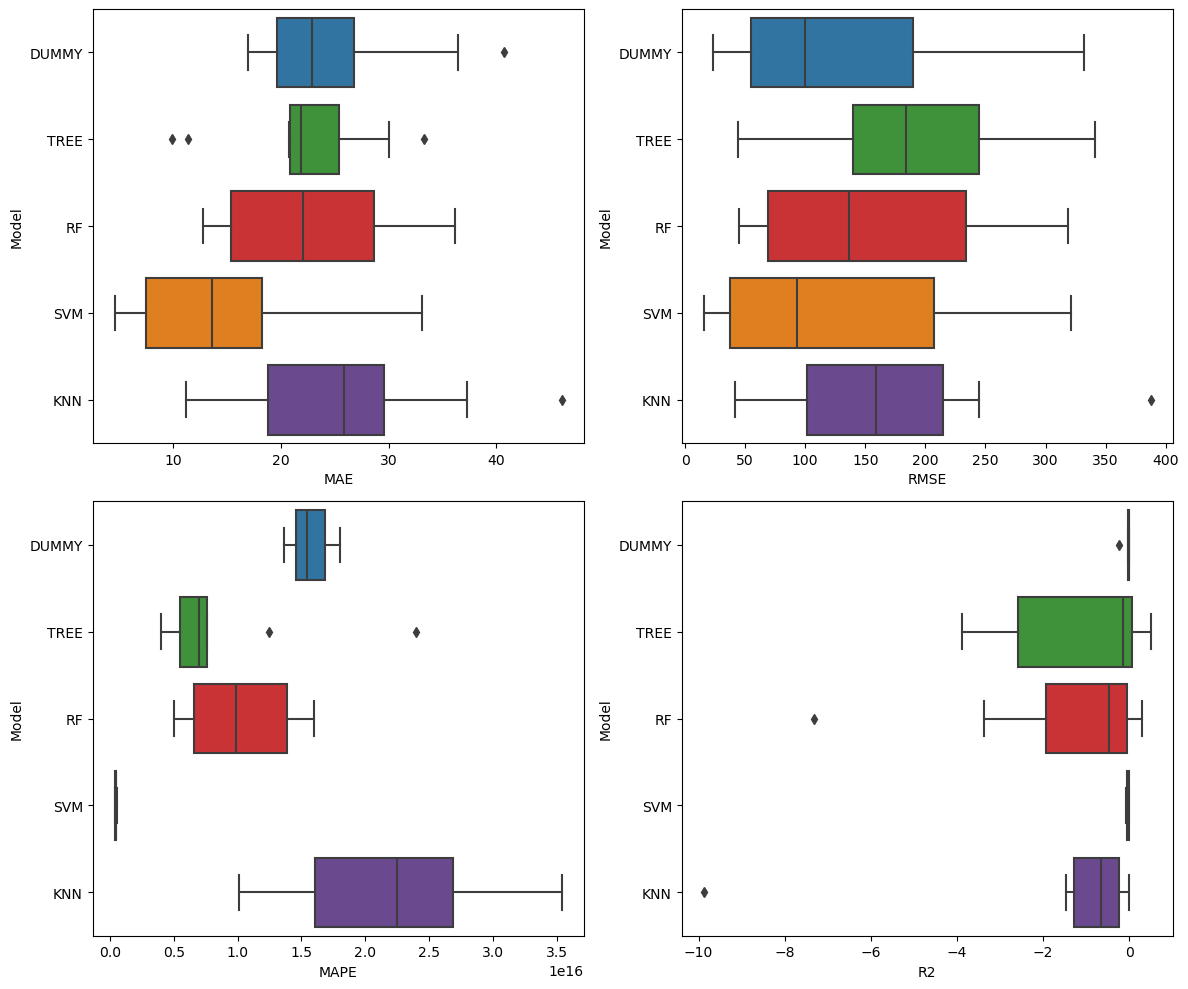

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(data=reg_metrics_new, x="MAE", y="Model", ax=axs[0, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_new, x="RMSE", y="Model", ax=axs[0, 1], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_new, x="MAPE", y="Model", ax=axs[1, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_new, x="R2", y="Model", ax=axs[1, 1], palette=sns.color_palette('Paired')[1::2])


plt.tight_layout()
plt.show()

## Add vectorized text

In [5]:
X = merged_df
X.drop(columns=['processed text'], inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4078 entries, 0 to 4077
Columns: 6007 entries, quotes to 𝗪𝗲𝗯𝘀𝗶𝘁𝗲
dtypes: bool(9), float64(5993), int64(5)
memory usage: 186.6 MB


In [6]:
reg_metrics_text = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'MAPE', 'R2'])

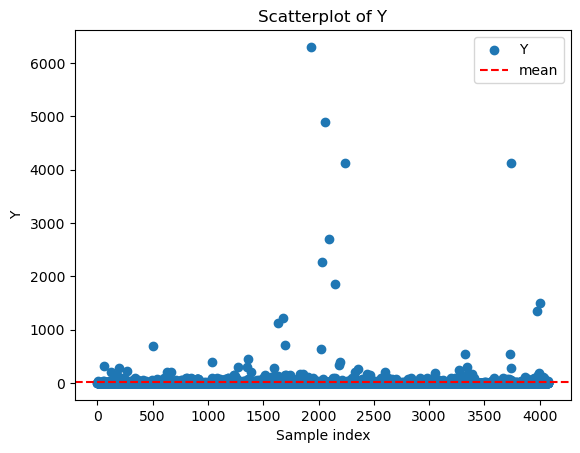

MSE Scores: 0    204.525090
1     97.527880
2    135.720441
3    236.334592
4     26.202099
5     40.654224
6     92.095866
7     19.751738
8    248.802697
9    326.567905
Name: RMSE, dtype: float64
Mean MSE: 142.8182532509367


In [7]:
dummy_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in dummy_kfolds.split(X):
    dummy_regressor = DummyRegressor()
    dummy_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_dummy_reg = dummy_regressor.predict(X.iloc[test_idx])
    current_dummy_mae = mean_absolute_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_mse = mean_squared_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_rmse = np.sqrt(current_dummy_mse)
    current_dummy_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_r2 = r2_score(Y.iloc[test_idx], y_dummy_reg)
    reg_metrics_text.loc[len(reg_metrics_text)] = ['DUMMY', current_dummy_mae, current_dummy_rmse, current_dummy_mape, current_dummy_r2]

# Dovrebbe essere lo stesso di fare:
# lin_regressor = LinearRegression()
# Y_reshaped = Y.values.reshape(-1, 1)

# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_text.loc[len(reg_metrics_text)] = ['DUMMY', mae_scores, mse_scores, mape_scores]


#Scatterplot of Y
mean_y = np.mean(Y)
plt.scatter(np.arange(len(Y)), Y, label='Y')
plt.axhline(y=mean_y, color='r', linestyle='--', label='mean')    # Plot the mean
plt.title('Scatterplot of Y')
plt.xlabel('Sample index')
plt.ylabel('Y')
plt.legend()
plt.show()

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_text.loc[reg_metrics_text['Model']=='DUMMY','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_text.loc[reg_metrics_text['Model']=='DUMMY','RMSE'])}")

In [8]:
# Decision Tree Regressor
# Initialize a decision tree regressor instance
tree_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in tree_kfolds.split(X):
    tree_regressor = DecisionTreeRegressor()
    tree_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_tree_reg = tree_regressor.predict(X.iloc[test_idx])
    current_tree_mae = mean_absolute_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_mse = mean_squared_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_rmse = np.sqrt(current_tree_mse)
    current_tree_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_r2 = r2_score(Y.iloc[test_idx], y_tree_reg)
    reg_metrics_text.loc[len(reg_metrics_text)] = ['TREE', current_tree_mae, current_tree_rmse, current_tree_mape, current_tree_r2]

# Dovrebbe essere lo stesso di fare:
# rf = RandomForestRegressor()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(rd, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(rf, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(rf, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_text.loc[len(reg_metrics_text)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_text.loc[reg_metrics_text['Model']=='TREE','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_text.loc[reg_metrics_text['Model']=='TREE','RMSE'])}")

MSE Scores: 10    234.394707
11    347.207325
12    321.375734
13    251.383080
14    334.831495
15     83.918664
16    460.936953
17     37.061763
18    337.623961
19    431.225914
Name: RMSE, dtype: float64
Mean MSE: 283.9959595225462


In [9]:
# Random Forest Regressor
# Initialize a random forest regressor instance
rf_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in rf_kfolds.split(X):
    rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=100, random_state=42)
    rf_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_rf_reg = rf_regressor.predict(X.iloc[test_idx])
    current_rf_mae = mean_absolute_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_mse = mean_squared_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_rmse = np.sqrt(current_rf_mse)
    current_rf_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_r2 = r2_score(Y.iloc[test_idx], y_rf_reg)
    reg_metrics_text.loc[len(reg_metrics_text)] = ['RF', current_rf_mae, current_rf_rmse, current_rf_mape, current_rf_r2]
     
# Dovrebbe essere lo stesso di fare:
# dummy_regressor = DummyRegressor()

# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(lin_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(lin_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(lin_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_text.loc[len(reg_metrics_text)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_text.loc[reg_metrics_text['Model']=='RF','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_text.loc[reg_metrics_text['Model']=='RF','RMSE'])}")

MSE Scores: 20    101.778962
21    439.489873
22     56.812994
23     34.052336
24    203.521102
25     50.658023
26    110.275925
27    161.023583
28     62.266913
29     45.767853
Name: RMSE, dtype: float64
Mean MSE: 126.5647564663137


### TODO: STANDARDIZE THE COVARIATES FOR SVM!!!

In [10]:
sv_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in sv_kfolds.split(X):
    sv_regressor = SVR()
    sv_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_sv_reg = sv_regressor.predict(X.iloc[test_idx])
    current_sv_mae = mean_absolute_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_mse = mean_squared_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_rmse = np.sqrt(current_sv_mse)
    current_sv_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_r2 = r2_score(Y.iloc[test_idx], y_sv_reg)
    reg_metrics_text.loc[len(reg_metrics_text)] = ['SVM', current_sv_mae, current_sv_rmse, current_sv_mape, current_sv_r2]

# Dovrebbe essere lo stesso di fare:
# sv_regressor = SVR()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(sv_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(sv_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(sv_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_text.loc[len(reg_metrics_text)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_text.loc[reg_metrics_text['Model']=='SVM','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_text.loc[reg_metrics_text['Model']=='SVM','RMSE'])}")

MSE Scores: 30    115.078604
31     83.166937
32     27.668926
33     51.789749
34    135.131644
35    319.188148
36    220.344960
37     69.231558
38    330.910271
39     23.989498
Name: RMSE, dtype: float64
Mean MSE: 137.65002954000488


In [11]:
knn_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in knn_kfolds.split(X):
    knn_regressor = KNeighborsRegressor()
    knn_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_knn_reg = knn_regressor.predict(X.iloc[test_idx])
    current_knn_mae = mean_absolute_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_mse = mean_squared_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_rmse = np.sqrt(current_knn_mse)
    current_knn_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_r2 = r2_score(Y.iloc[test_idx], y_knn_reg)
    reg_metrics_text.loc[len(reg_metrics_text)] = ['KNN', current_knn_mae, current_knn_rmse, current_knn_mape, current_knn_r2]

# Dovrebbe essere lo stesso di fare:
# knn_regressor = KNeighborsRegressor()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(knn_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(knn_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(knn_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_new.loc[len(reg_metrics_new)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_text.loc[reg_metrics_text['Model']=='KNN','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_text.loc[reg_metrics_text['Model']=='KNN','RMSE'])}")

MSE Scores: 40    100.520856
41    261.913289
42    220.844930
43    176.581117
44    382.291642
45    127.680693
46    152.875232
47     65.177026
48     99.633640
49    101.311085
Name: RMSE, dtype: float64
Mean MSE: 168.8829509399658


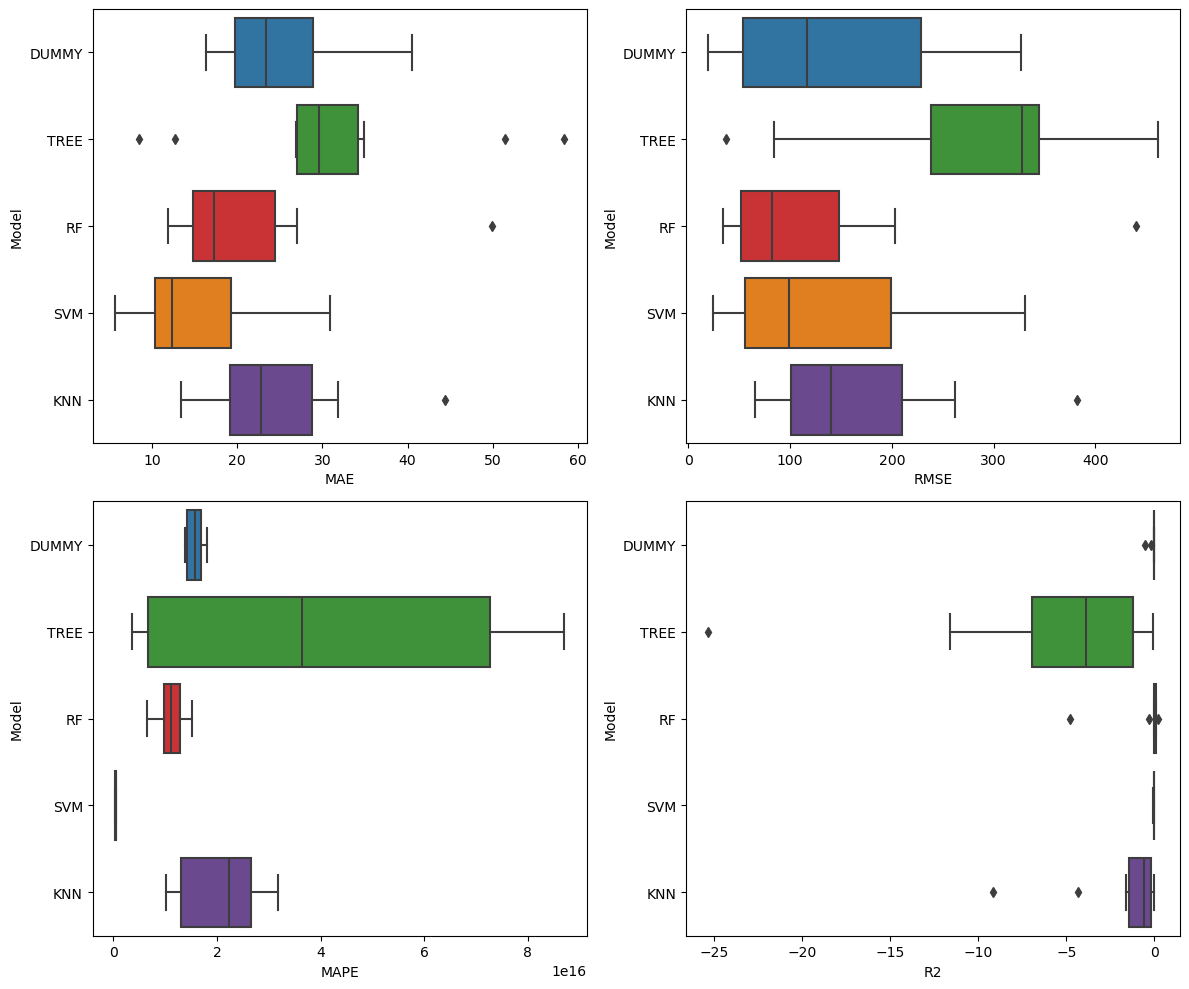

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(data=reg_metrics_text, x="MAE", y="Model", ax=axs[0, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_text, x="RMSE", y="Model", ax=axs[0, 1], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_text, x="MAPE", y="Model", ax=axs[1, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_text, x="R2", y="Model", ax=axs[1, 1], palette=sns.color_palette('Paired')[1::2])


plt.tight_layout()
plt.show()

### Compare the three models

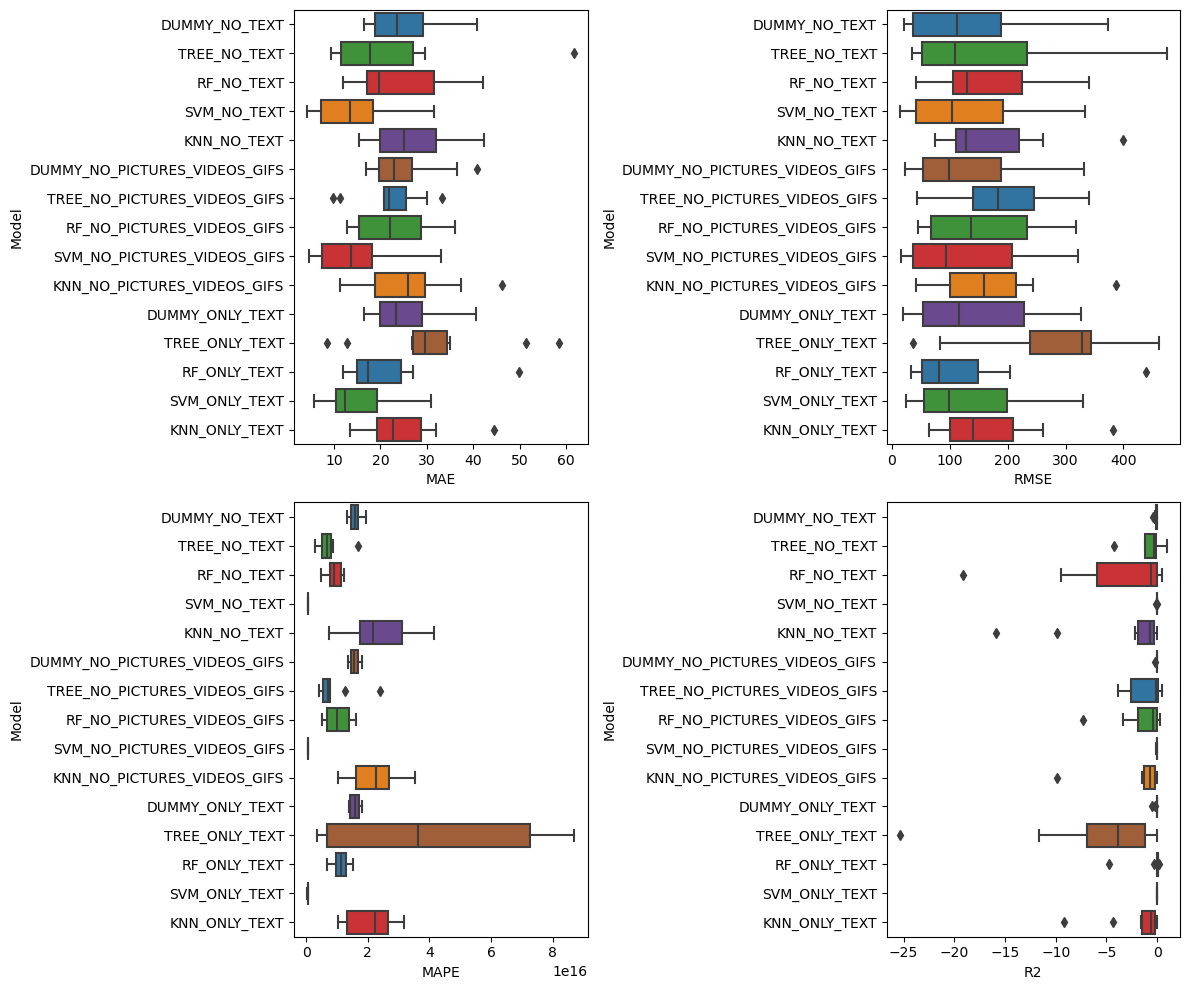

In [34]:
# Compare the results of the models with or without text features
reg_metrics['Model'] = reg_metrics['Model'] + '_NO_TEXT'
reg_metrics_new['Model'] = reg_metrics_new['Model'] + '_NO_PICTURES_VIDEOS_GIFS'
reg_metrics_text['Model'] = reg_metrics_text['Model'] + '_ONLY_TEXT'
reg_metrics = pd.concat([reg_metrics, reg_metrics_new, reg_metrics_text])
reg_metrics.reset_index(inplace=True, drop=True)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(data=reg_metrics, x="MAE", y="Model", ax=axs[0, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="RMSE", y="Model", ax=axs[0, 1], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="MAPE", y="Model", ax=axs[1, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="R2", y="Model", ax=axs[1, 1], palette=sns.color_palette('Paired')[1::2])

plt.tight_layout()
plt.show()